# Introduction
Data Source
https://archive.ics.uci.edu/ml/datasets/Census+Income

Goal: finding the key factors contributing to high Income


In [4]:
import warnings
warnings.simplefilter('ignore')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
#import lightgbm as lgb
import numpy as np, scipy.stats as st
%matplotlib inline
import  warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import auc, roc_curve, classification_report
import xgboost as xgb
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import scale 
#import shap
%matplotlib inline

# Index
* [Load the data](#Load-the-data)
    * [Check Missing Value](#Check-Missing-Value)
* [Feature Engineering](#Feature-Engineering)
    * [Factor Analysis](#Factor-Analysis)
    * [Distribution Analysis](#Distribution-Analysis)
    * [Correlation Analysis](#Correlation-Analysis)
    * [Chi Squre Test](#Chi-Squre-Test)    
* [Model Building & Training](#Model-Building-&-Training)
    * [Key factors contributing to high vs low income](#Key-factors-contributing-to-high-vs-low-income)
    * [Profile for a successful investor](#Profile-for-a-successful-investor)

    

## Load the data


In [5]:
training_data = pd.read_csv('adult.data.txt', sep=",", header=None)
testing_data = pd.read_csv('adult.test.txt', sep=",", header=None)
training_data['dataset']='training_data'
testing_data['dataset']='testing_data'
all_data = pd.concat([training_data,testing_data])
all_data.columns=["age",'workclass','fnlwgt','education','education_num',
                       'marital_status', 'occupation','relationship','race','sex',
                       'capital_gain','capital_loss','hours_per_week','native_country','income','dataset']
all_data.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income,dataset
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K,training_data
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K,training_data
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K,training_data
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K,training_data
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K,training_data


## Feature Engineering 

In [6]:
def convert_str(col_list):
    for col in col_list:
        #all_data[col] = all_data[col].astype('category')
        all_data[col]=all_data[col].apply(lambda x: x.strip().lower())
    
convert_str(['workclass','education','marital_status','occupation','relationship','race','sex','native_country','income'])




In [7]:
# Create income dummy 
# 1: income > 50K 
# 0: income <= 50K

all_data['income_dummy']= all_data['income'].apply(lambda x: 1 if '>' in x else 0)
series= all_data['income_dummy'].value_counts()
(series/series.sum() * 100).to_frame(name='pec')

,pec
0,76.071823
1,23.928177


## Check Missing Value
missing values in workclass, occupation and native_country

In [8]:
## check data with missing values
df_missing = all_data[all_data.values=='?']
df_missing.isin(['?']).sum(axis=0)
df_missing.groupby('dataset').size()
all_data.to_csv('all_data.csv', index=False)

In [9]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48842 entries, 0 to 16280
Data columns (total 17 columns):
age               48842 non-null int64
workclass         48842 non-null object
fnlwgt            48842 non-null int64
education         48842 non-null object
education_num     48842 non-null int64
marital_status    48842 non-null object
occupation        48842 non-null object
relationship      48842 non-null object
race              48842 non-null object
sex               48842 non-null object
capital_gain      48842 non-null int64
capital_loss      48842 non-null int64
hours_per_week    48842 non-null int64
native_country    48842 non-null object
income            48842 non-null object
dataset           48842 non-null object
income_dummy      48842 non-null int64
dtypes: int64(7), object(10)
memory usage: 6.7+ MB


In [10]:
# Calculate capital profit 
all_data['capital_profit']=all_data['capital_gain']-all_data['capital_loss']
all_data.drop(columns=['capital_gain','capital_loss','income','fnlwgt'], axis=1, inplace=True)

In [11]:
# Create dummy variable for good investor
all_data['good_investor']= all_data['capital_profit'].apply(lambda x: 1 if x>0 else 0)

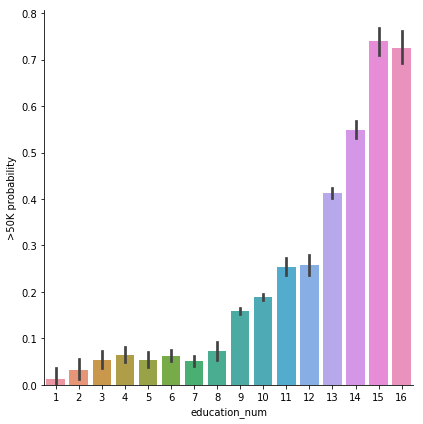

In [12]:
# Explore Education Num vs Income
g = sns.factorplot(x="education_num",y="income_dummy",data=all_data,kind="bar",size = 6)

g = g.set_ylabels(">50K probability")
## segment eduation into 3 groups 


In [13]:
## segment features
def hour_seg( row):
    if row < 40:
        return 'part_time'
    elif row == 40:
        return 'full_time'
    elif row>40:
        return 'over-time'
    else:
        return 'unkonw'

def nativity_seg(row):
    if row =='united-states':
        return 1
    else :
        return 0
    
def marital_seg(row):
    if row in ['husband','wife']:
        return 1
    else: 
        return 0
    
def education_seg(row):
    if row <9:
        return 'pre-college'
    elif row <13 and row >=9:
        return 'college'
    elif row >=13:
        return 'bachelor-advance-degree'

def work_seg(row):
    if row in ['prof-specialty','exec-managerial']:
        return row
    else:
        return 'others'


In [14]:
all_data['hour_seg'] = all_data.hours_per_week.apply(lambda x:hour_seg(x) )
all_data['is_US'] = all_data.native_country.apply(lambda x:nativity_seg(x) )
all_data['is_couple'] = all_data.relationship.apply(lambda x:marital_seg(x) )
all_data['education_seg'] = all_data.education_num.apply(lambda x:education_seg(x) )
#all_data['work_seg'] = all_data.workclass.apply(lambda x:work_seg(x) )
all_data['is_male']=all_data['sex'].apply(lambda x: 1 if x=='male'  else 0 )
all_data['work_seg'] = all_data.occupation.apply(lambda x:work_seg(x) )


## Factor Analysis

In [15]:
def factor_analysis(col):
    g = sns.factorplot(x=col,y="income_dummy",data=all_data,kind="bar",size = 6)
    g = g.set_ylabels(">50K probability")
    g=g.set_xticklabels(rotation=30)
#    for i, bar in enumerate(g.ax.patches):
#        h = bar.get_height()

#        print h

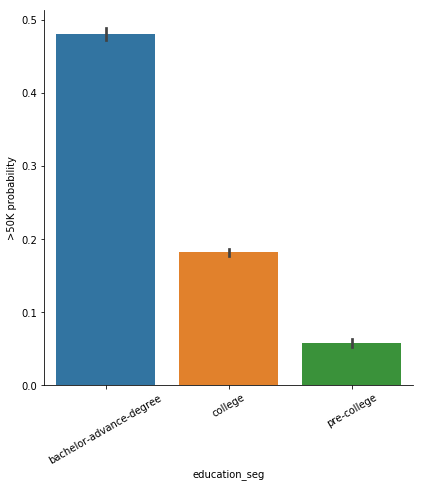

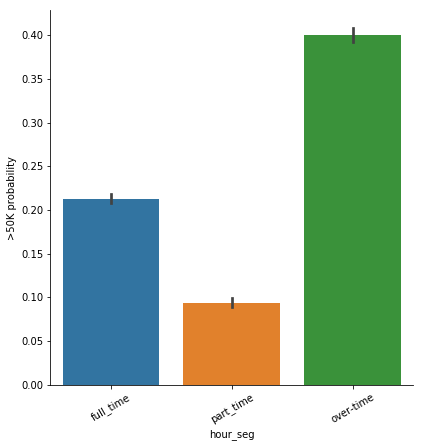

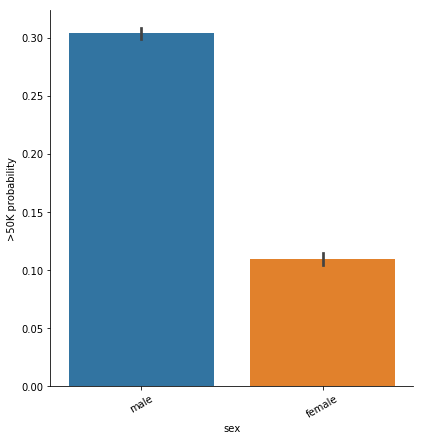

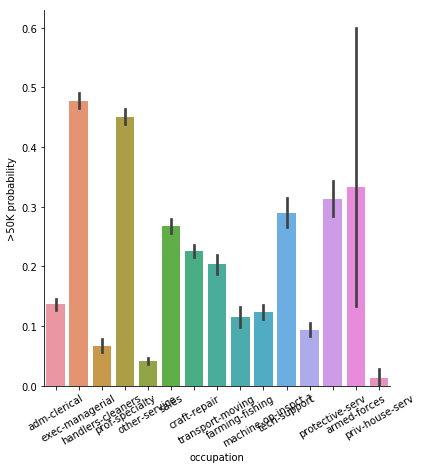

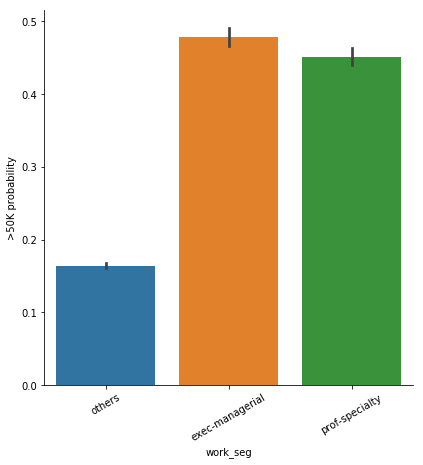

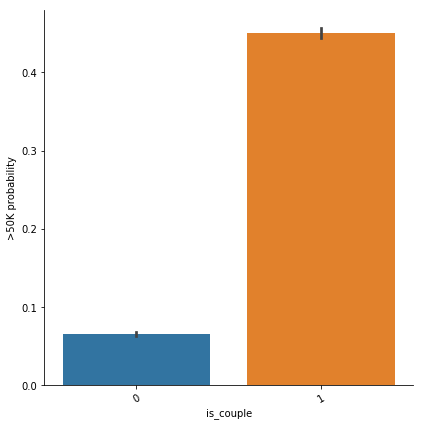

In [16]:
# select segmentation vs. income dummy
factor_analysis("education_seg")
factor_analysis("hour_seg")
factor_analysis("sex")
factor_analysis("occupation")
factor_analysis("work_seg")
factor_analysis("is_couple")

## Distribution Analysis

44.275177547702576
36.87218409366169
43.0
34.0


Text(0,0.5,'Density')

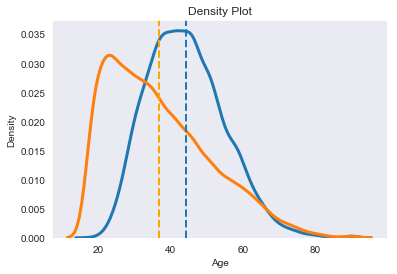

In [17]:
# distribution of age vs income 
sns.set_style("dark")
subset1 = all_data[all_data['income_dummy'] == 1]
subset0 = all_data[all_data['income_dummy'] == 0]   
# Draw the density plot
sns.distplot(subset1['age'], hist = False, kde = True,
             kde_kws = {'linewidth': 3}
             #,label = 'Income > 50K'
            )
# Draw the density plot
sns.distplot(subset0['age'], hist = False, kde = True,
             kde_kws = {'linewidth': 3}
             #,label = 'Income <= 50K'
            )   
print(subset1['age'].mean())
print(subset0['age'].mean())
print(subset1['age'].median())
print(subset0['age'].median())

plt.axvline(subset1['age'].mean(), linestyle='dashed', linewidth=2)
plt.axvline(subset0['age'].mean(), linestyle='dashed', linewidth=2, color='orange')

#plt.axvline(subset0['age'].median(), linestyle='dashed', linewidth=2)

# Plot formatting
#plt.legend(prop={'size': 16}, title = 'Airline')
plt.title('Density Plot')
plt.xlabel('Age')
plt.ylabel('Density')

In [18]:
# calculate confidence interval
import numpy as np
import scipy.stats


def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h
mean_confidence_interval(subset1['age'])


(44.275177547702576, 44.083723894052625, 44.46663120135253)

In [19]:
mean_confidence_interval(subset0['age'])

(36.87218409366169, 36.728767454829985, 37.01560073249339)

0.85       0.0
0.90       0.0
0.95    5013.0
Name: capital_profit, dtype: float64

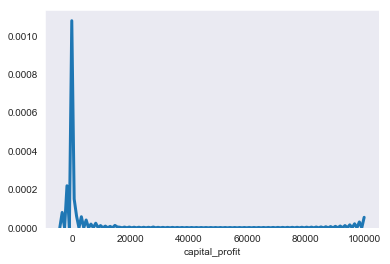

In [20]:
# disttribution of capital profit
sns.distplot(all_data['capital_profit'], hist = False, kde = True,
             kde_kws = {'linewidth': 3})
all_data['capital_profit'].quantile([.85, .90, .95])

0.85    0.000000
0.90    0.000000
0.95    8.552367
Name: log_capital_profit, dtype: float64

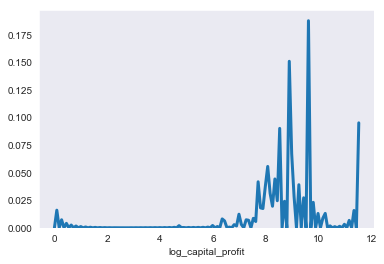

In [21]:
# disttribution of lot(capital profit)
all_data['log_capital_profit'] = np.log(all_data['capital_profit']+1)
sns.distplot(all_data['log_capital_profit'], hist = False, kde = True,
             kde_kws = {'linewidth': 3})
all_data['log_capital_profit'].quantile([.85, .90, .95])

In [22]:
all_data.replace('?', 'unknown', inplace=True)
all_data.head()

,age,workclass,education,education_num,marital_status,occupation,relationship,race,sex,hours_per_week,...,income_dummy,capital_profit,good_investor,hour_seg,is_US,is_couple,education_seg,is_male,work_seg,log_capital_profit
0,39,state-gov,bachelors,13,never-married,adm-clerical,not-in-family,white,male,40,...,0,2174,1,full_time,1,0,bachelor-advance-degree,1,others,7.684784
1,50,self-emp-not-inc,bachelors,13,married-civ-spouse,exec-managerial,husband,white,male,13,...,0,0,0,part_time,1,1,bachelor-advance-degree,1,exec-managerial,0.000000
2,38,private,hs-grad,9,divorced,handlers-cleaners,not-in-family,white,male,40,...,0,0,0,full_time,1,0,college,1,others,0.000000
3,53,private,11th,7,married-civ-spouse,handlers-cleaners,husband,black,male,40,...,0,0,0,full_time,1,1,pre-college,1,others,0.000000
4,28,private,bachelors,13,married-civ-spouse,prof-specialty,wife,black,female,40,...,0,0,0,full_time,0,1,bachelor-advance-degree,0,prof-specialty,0.000000


In [23]:
all_data.describe(include='all')

,age,workclass,education,education_num,marital_status,occupation,relationship,race,sex,hours_per_week,...,income_dummy,capital_profit,good_investor,hour_seg,is_US,is_couple,education_seg,is_male,work_seg,log_capital_profit
count,48842.000000,48842,48842,48842.000000,48842,48842,48842,48842,48842,48842.000000,...,48842.000000,48842.000000,48842.000000,48842,48842.000000,48842.000000,48842,48842.000000,48842,46560.000000
unique,NaN,9,16,NaN,7,15,6,5,2,NaN,...,NaN,NaN,NaN,3,NaN,NaN,3,NaN,3,NaN
top,NaN,private,hs-grad,NaN,married-civ-spouse,prof-specialty,husband,white,male,NaN,...,NaN,NaN,NaN,full_time,NaN,NaN,college,NaN,others,NaN
freq,NaN,33906,15784,NaN,22379,6172,19716,41762,32650,NaN,...,NaN,NaN,NaN,22803,NaN,NaN,30324,NaN,36584,NaN
mean,38.643585,NaN,NaN,10.078089,NaN,NaN,NaN,NaN,NaN,40.422382,...,0.239282,991.565313,0.082613,NaN,0.897424,0.451394,NaN,0.668482,NaN,0.764252
std,13.710510,NaN,NaN,2.570973,NaN,NaN,NaN,NaN,NaN,12.391444,...,0.426649,7475.549906,0.275300,NaN,0.303407,0.497637,NaN,0.470764,NaN,2.499239
min,17.000000,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,1.000000,...,0.000000,-4356.000000,0.000000,NaN,0.000000,0.000000,NaN,0.000000,NaN,0.000000
25%,28.000000,NaN,NaN,9.000000,NaN,NaN,NaN,NaN,NaN,40.000000,...,0.000000,0.000000,0.000000,NaN,1.000000,0.000000,NaN,0.000000,NaN,0.000000
50%,37.000000,NaN,NaN,10.000000,NaN,NaN,NaN,NaN,NaN,40.000000,...,0.000000,0.000000,0.000000,NaN,1.000000,0.000000,NaN,1.000000,NaN,0.000000
75%,48.000000,NaN,NaN,12.000000,NaN,NaN,NaN,NaN,NaN,45.000000,...,0.000000,0.000000,0.000000,NaN,1.000000,1.000000,NaN,1.000000,NaN,0.000000


## Correlation Analysis

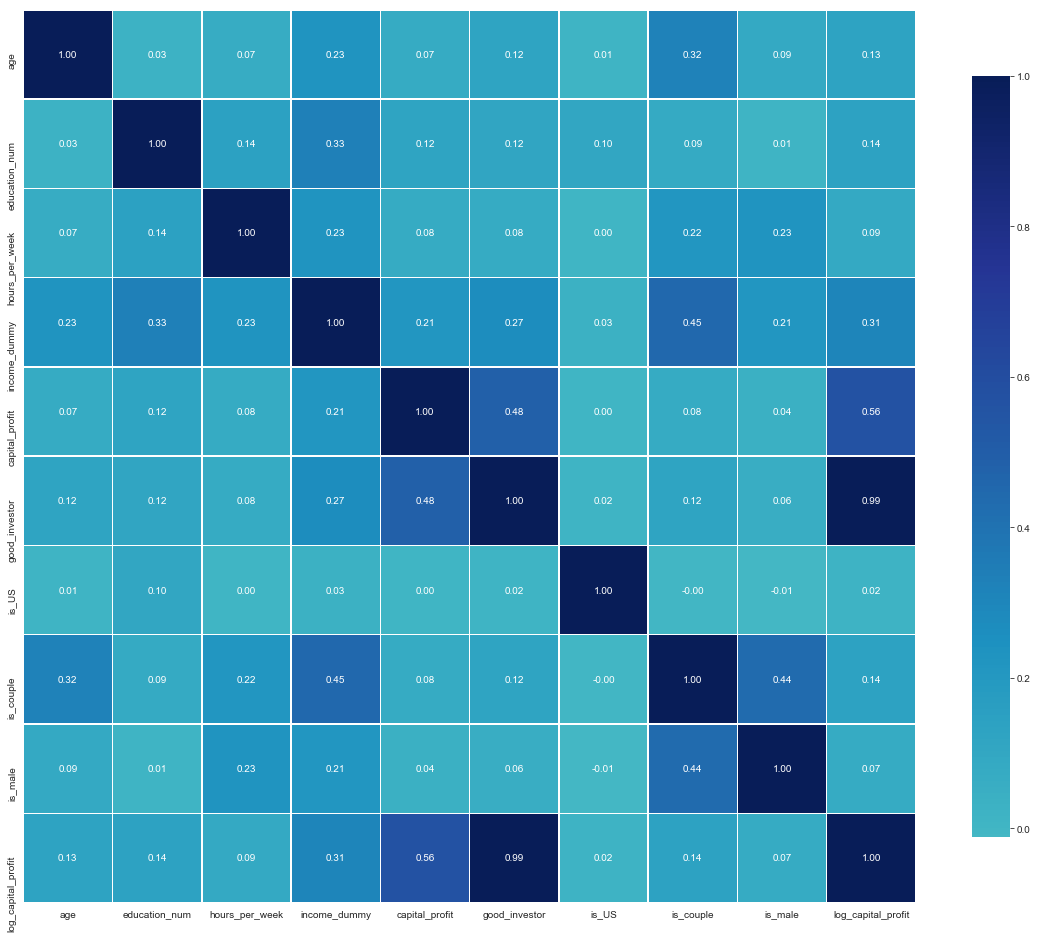

In [24]:
def correlation_heatmap(train):
    correlations = train.corr()

    fig, ax = plt.subplots(figsize=(20,20))
    sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f', cmap="YlGnBu",
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70}
                )
    plt.show();
    
correlation_heatmap(all_data.select_dtypes(exclude='object'))

### Chi Squre Test 
for categorical variables vs. income_dummy

In [25]:
from scipy.stats import chi2_contingency
for i in all_data.loc[:, all_data.columns != 'dataset'].select_dtypes(include='object').columns:
    print (i)
    t=pd.crosstab(all_data['income_dummy'],all_data[i])
    #print(t)
    dof=chi2_contingency(t)[1]
    print 'p-value' ,dof

workclass
p-value 0.0
education
p-value 0.0
marital_status
p-value 0.0
occupation
p-value 0.0
relationship
p-value 0.0
race
p-value 4.2843777102233777e-104
sex
p-value 0.0
native_country
p-value 1.0356184275397302e-70
hour_seg
p-value 0.0
education_seg
p-value 0.0
work_seg
p-value 0.0


Check Value Counts for Categorical Variables

In [26]:
#check value counts for categorical variables 
for col in all_data.select_dtypes(include='object').columns: 
    series = pd.value_counts(all_data[col])
    cnt_pec= pd.concat([all_data[col].value_counts().to_frame(name='count'), (series/series.sum() * 100).to_frame(name='pec')]
         ,axis=1)

    mean = all_data[['income_dummy', col]].groupby(col).mean()
    cnt_pec_mean = pd.concat([cnt_pec,mean], axis=1).sort_values(by=['pec','income_dummy'], ascending =False)
    print'*********',col
    print(cnt_pec_mean)

    #print((series/series.sum() * 100).to_frame(name='pec'))



********* workclass
                  count        pec  income_dummy
private           33906  69.419762      0.217867
self-emp-not-inc   3862   7.907129      0.278871
local-gov          3136   6.420703      0.295599
unknown            2799   5.730724      0.094677
state-gov          1981   4.055935      0.267542
self-emp-inc       1695   3.470374      0.553392
federal-gov        1432   2.931903      0.391760
without-pay          21   0.042996      0.095238
never-worked         10   0.020474      0.000000
********* education
              count        pec  income_dummy
hs-grad       15784  32.316449      0.158578
some-college  10878  22.271815      0.189649
bachelors      8025  16.430531      0.412835
masters        2657   5.439990      0.549116
assoc-voc      2061   4.219729      0.253275
11th           1812   3.709922      0.050773
assoc-acdm     1601   3.277917      0.257964
10th           1389   2.843864      0.062635
7th-8th         955   1.955284      0.064921
prof-school     834 

There are significant gaps in Census Attributes by Gender (67%Male, 33%Female) and Race (85%White, 15%others)

In [27]:
df_new=pd.get_dummies(all_data,columns=all_data.drop(['dataset','good_investor'],axis=1).select_dtypes(include='object').columns)


In [28]:
df_new.columns.to_frame()
all_data.columns.to_frame()

,0
age,age
workclass,workclass
education,education
education_num,education_num
marital_status,marital_status
occupation,occupation
relationship,relationship
race,race
sex,sex
hours_per_week,hours_per_week


In [29]:
X_decision_tree = pd.get_dummies(all_data.drop(['capital_profit','dataset','good_investor',
                                 'education','education_num','marital_status','occupation','capital_profit',
                                'relationship','native_country','workclass','hours_per_week'], axis=1))
X_decision_tree.columns.to_frame()

,0
age,age
income_dummy,income_dummy
is_US,is_US
is_couple,is_couple
is_male,is_male
log_capital_profit,log_capital_profit
race_amer-indian-eskimo,race_amer-indian-eskimo
race_asian-pac-islander,race_asian-pac-islander
race_black,race_black
race_other,race_other


In [30]:
X_decision_tree.head()

,age,income_dummy,is_US,is_couple,is_male,log_capital_profit,race_amer-indian-eskimo,race_asian-pac-islander,race_black,race_other,...,sex_male,hour_seg_full_time,hour_seg_over-time,hour_seg_part_time,education_seg_bachelor-advance-degree,education_seg_college,education_seg_pre-college,work_seg_exec-managerial,work_seg_others,work_seg_prof-specialty
0,39,0,1,0,1,7.684784,0,0,0,0,...,1,1,0,0,1,0,0,0,1,0
1,50,0,1,1,1,0.000000,0,0,0,0,...,1,0,0,1,1,0,0,1,0,0
2,38,0,1,0,1,0.000000,0,0,0,0,...,1,1,0,0,0,1,0,0,1,0
3,53,0,1,1,1,0.000000,0,0,1,0,...,1,1,0,0,0,0,1,0,1,0
4,28,0,0,1,0,0.000000,0,0,1,0,...,0,1,0,0,1,0,0,0,0,1


In [31]:
#create input dataset without including target variable( class column)
X=df_new.drop(['capital_profit','income_dummy'], axis=1)
#Create the target data with only class column
y_income=df_new['income_dummy']
y_capital = all_data['good_investor']

In [32]:
X_train=X[df_new.dataset=='training_data']
X_test=X[df_new.dataset=='testing_data']
y_income_train=y_income[df_new.dataset=='training_data']
y_income_test=y_income[df_new.dataset=='testing_data']

In [33]:
X_investor_train=X[df_new.dataset=='training_data'].drop(["good_investor",'log_capital_profit','dataset'], axis=1)
X_investor_test=X[df_new.dataset=='testing_data'].drop(["good_investor",'log_capital_profit','dataset'], axis=1)
y_investor_train = y_capital[df_new.dataset=='training_data']
y_investor_test = y_capital[df_new.dataset=='testing_data']


In [34]:
X_train=X_train.loc[:, X_train.columns != 'dataset' ]
X_test=X_test.loc[:, X_test.columns != 'dataset']
X= X.drop('dataset', axis=1)

### Model Building & Training 


In [35]:
def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df2=fi_df.nlargest(20,'feature_importance')
    print(fi_df2)
    fi_df2.to_csv(model_type+'_feature_importance.csv', index=False)
    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df2['feature_importance'], y=fi_df2['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

In [36]:
#import confusion matrix , classification report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
xgb_model.fit(X_train, y_income_train)

xgb_prediction = xgb_model.predict(X_test)

print(confusion_matrix(y_income_test, xgb_prediction))
print(classification_report(y_income_test, xgb_prediction,target_names=["Low-Income", "High-Income"]))

[[11790   645]
 [ 1522  2324]]
              precision    recall  f1-score   support

  Low-Income       0.89      0.95      0.92     12435
 High-Income       0.78      0.60      0.68      3846

   micro avg       0.87      0.87      0.87     16281
   macro avg       0.83      0.78      0.80     16281
weighted avg       0.86      0.87      0.86     16281



## Key factors contributing to high vs low income

     feature_importance                      feature_names
5              0.441596                          is_couple
35             0.088413  marital_status_married-civ-spouse
117            0.083673                    work_seg_others
1              0.061862                      education_num
7              0.043162                 log_capital_profit
0              0.023793                                age
58             0.020615             relationship_own-child
47             0.020051           occupation_other-service
2              0.018729                     hours_per_week
44             0.013561         occupation_farming-fishing
3              0.013351                      good_investor
6              0.010023                            is_male
52             0.009627            occupation_tech-support
51             0.009107                   occupation_sales
43             0.008819         occupation_exec-managerial
8              0.008752              workclass_federal-g

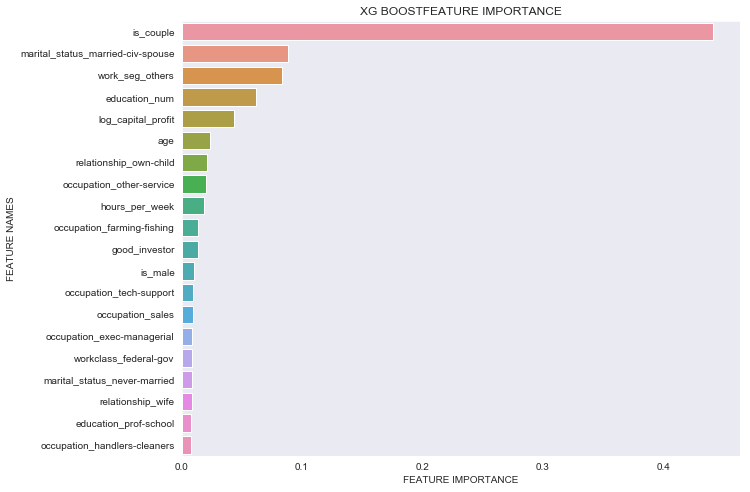

In [37]:
plot_feature_importance(xgb_model.feature_importances_,X_train.columns,'XG BOOST')


## Profile for a successful investor

In [38]:
#import confusion matrix , classification report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

xgb_model2 = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
xgb_model2.fit(X_investor_train, y_investor_train)

xgb_prediction2 = xgb_model2.predict(X_investor_test)

print(confusion_matrix(y_investor_test, xgb_prediction2))
print(classification_report(y_investor_test, xgb_prediction2,target_names=["Poor-Investor", "Good-Investor"]))

[[14957     1]
 [ 1322     1]]
               precision    recall  f1-score   support

Poor-Investor       0.92      1.00      0.96     14958
Good-Investor       0.50      0.00      0.00      1323

    micro avg       0.92      0.92      0.92     16281
    macro avg       0.71      0.50      0.48     16281
 weighted avg       0.88      0.92      0.88     16281



     feature_importance                      feature_names
33             0.140642  marital_status_married-civ-spouse
115            0.068311                    work_seg_others
1              0.060320                      education_num
0              0.041036                                age
4              0.038857                          is_couple
45             0.034013           occupation_other-service
56             0.032574             relationship_own-child
10             0.029587             workclass_self-emp-inc
50             0.028401            occupation_tech-support
29             0.028105              education_prof-school
84             0.023432               native_country_india
2              0.023335                     hours_per_week
47             0.021747          occupation_prof-specialty
49             0.019799                   occupation_sales
41             0.016928         occupation_exec-managerial
91             0.016613              native_country_mexi

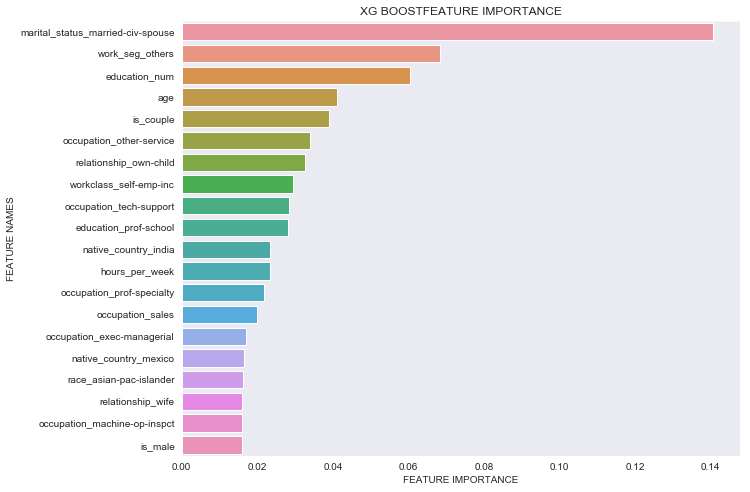

In [39]:
plot_feature_importance(xgb_model2.feature_importances_,X_investor_train.columns,'XG BOOST')